In [6]:
RANDOM_SEED = 42  # random.randint(1,100)
# DATASET_PATH = Path('/Users/tomcounsell/src/ai/datasets/dogs/images/')
EXAMPLE_IMAGE_FILEPATH = DATASET_PATH/'n02085782-Japanese_spaniel/n02085782_50.jpg'
AI_MODEL_FILENAME = 'model_export.pkl'

In [7]:
from fastai.vision.all import *
import random

In [ ]:
!curl -o ./images.tar "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
!tar -xf images.tar

In [11]:
DATASET_PATH = Path('Images');

In [12]:
print(DATASET_PATH)
Path.BASE_PATH = DATASET_PATH

Images


In [24]:
import re
def parse_breed_name(folder_name):
    return re.findall('.+/n\d+-([\w-]+)$', folder_name)[0].replace("_", " ").title()

def parse_ncode(folder_name):
    return re.findall('.+/(n\d+)-[\w-]+$', folder_name)[0]

BREED_NAMES = {parse_ncode(str(sub_dir)): parse_breed_name(str(sub_dir)) for sub_dir in DATASET_PATH.ls()}

def get_breed_from_filename(filename):
    return BREED_NAMES[re.findall('(n\d+).+.jpg$', str(filename))[0]]

print(f"Some dog breeds: {list(BREED_NAMES.values())[:5]}")

Some dog breeds: ['Chihuahua', 'Japanese Spaniel', 'Maltese Dog', 'Pekinese', 'Shih-Tzu']


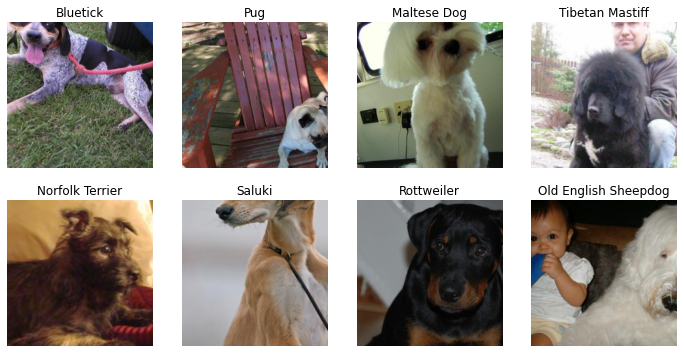

In [25]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=RANDOM_SEED),
    get_y=get_breed_from_filename,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dataloaders = dogs.dataloaders(DATASET_PATH)
dataloaders.show_batch(nrows=2, ncols=4)

In [28]:
from fastai.callback.fp16 import *
learn = cnn_learner(dataloaders, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

KeyboardInterrupt: 

In [27]:
learn.export(AI_MODEL_FILENAME)